In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.spatial import procrustes
from matplotlib.colors import ListedColormap



import mnist_reader

X_train, y_train = mnist_reader.load_mnist('data/mnist', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/mnist', kind='t10k')

#n = 30000
#np.random.seed(6333)
#ids = np.random.choice(range(60000),n)
#X_train, y_train = X_train[ids], y_train[ids]

n = X_train.shape[0]


X_train = X_train.astype(np.float32)
X_train = X_train/(np.max(X_train))
print(X_train.dtype)

classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9']

print(y_train)
print(X_train.shape, y_train.shape)


#set_up_parameters

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

float32
[5 0 4 ... 5 6 8]
(60000, 784) (60000,)


In [2]:
import numba
from numba import prange

#@numba.jit(nopython=True)
def map_rotate(y, rot_angle):
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    Y = y
    Y = rot_mat.dot(Y.T).T
    
    return Y

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val


In [3]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 10000
nB = 25000
nC = 25000

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]
SETB = X_train_rp[nA:nA+nB]
y_SETB = y_train_rp[nA:nA+nB]
SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC = y_train_rp[nA+nB:nA+nB+nC]

data1 = np.concatenate((SETA, SETB))
data2 = np.concatenate((SETA, SETC))


print(SETA.shape, SETB.shape, SETC.shape)

(10000, 784) (25000, 784) (25000, 784)


In [4]:
Com_set = np.concatenate((SETA,SETB,SETC))
y_com_set = np.concatenate((y_SETA, y_SETB, y_SETC))

sort_idx, dist = get_first_order_graph(Com_set,n_neighbors=Com_set.shape[0]-1)

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Completed  10000  of  60000
Completed  20000  of  60000
Completed  30000  of  60000
Completed  40000  of  60000
Completed  50000  of  60000
Completed  60000  of  60000


In [5]:
with open('MNIST_Aligned_NE_10_25_25.npy', 'rb') as f:
    embA_ne = np.load(f)
    embB_ne = np.load(f)
    embC_ne = np.load(f)

In [6]:
k_nn=5
T1_ne = my_trustworthiness(np.concatenate((embA_ne,embB_ne,embC_ne)),sort_idx,k_nn)

print(T1_ne)

0.9531873644819309


<IPython.core.display.Javascript object>


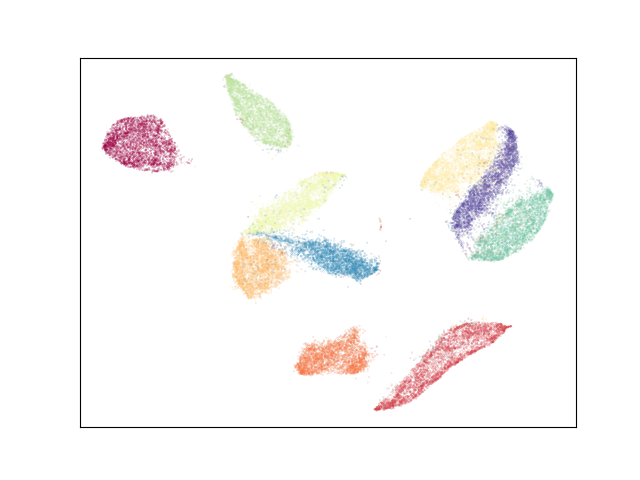

<IPython.core.display.Javascript object>


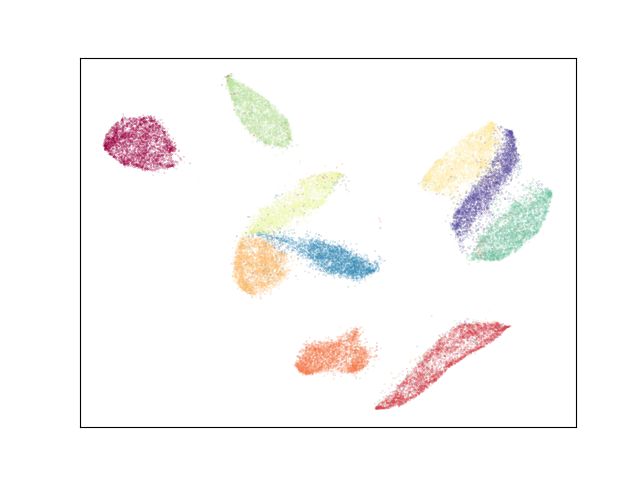

In [7]:
emb_set1 = np.concatenate((embA_ne, embB_ne))
emb_set1 = map_rotate(emb_set1, rot_angle=-40)
y_emb_set1 = np.concatenate((y_SETA, y_SETB))

embA_rot = embA_ne #map_rotate(embA_ne, rot_angle=40)

fig = plt.figure()
#plt.title('EM_SET_1')
plt.scatter(-emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot[:,0], -embA_rot[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.95, 8.50])
plt.ylim([-9.20, 7.1])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne10k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne, embC_ne))
emb_set2 = map_rotate(emb_set2, rot_angle=-40)
y_emb_set2 = np.concatenate((y_SETA,y_SETC))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(-emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot[:,0], -embA_rot[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.95, 8.50])
plt.ylim([-9.20, 7.1])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne10k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

In [8]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 5000
nB = 27500
nC = 27500

#SETA = X_train_rp[:nA]
y_SETA_ne5 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne5 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne5 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)


with open('MNIST_Aligned_NE_5_27.5_27.5.npy', 'rb') as f:
    embA_ne5 = np.load(f)
    embB_ne5 = np.load(f)
    embC_ne5 = np.load(f)

In [9]:
T1_ne5 = my_trustworthiness(np.concatenate((embA_ne5,embB_ne5,embC_ne5)),sort_idx,k_nn)

print(T1_ne5)

0.9514309406809797


<IPython.core.display.Javascript object>


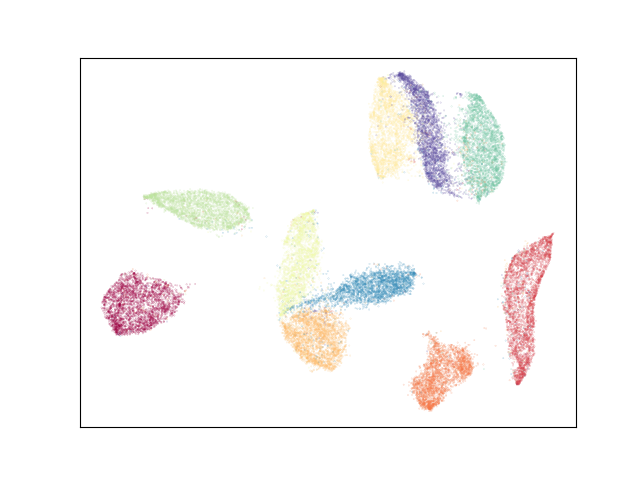

<IPython.core.display.Javascript object>


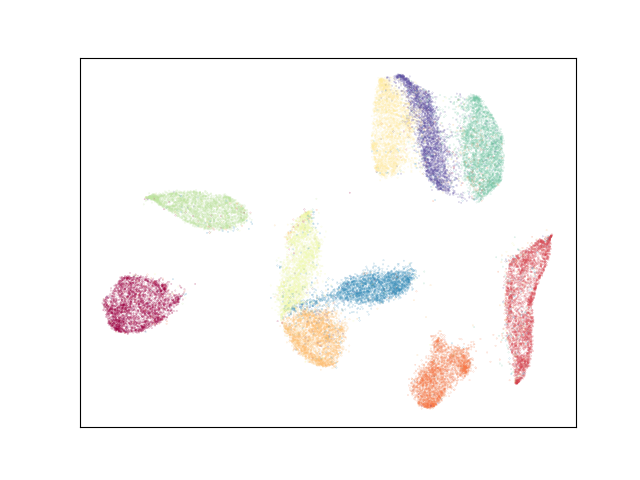

<IPython.core.display.Javascript object>


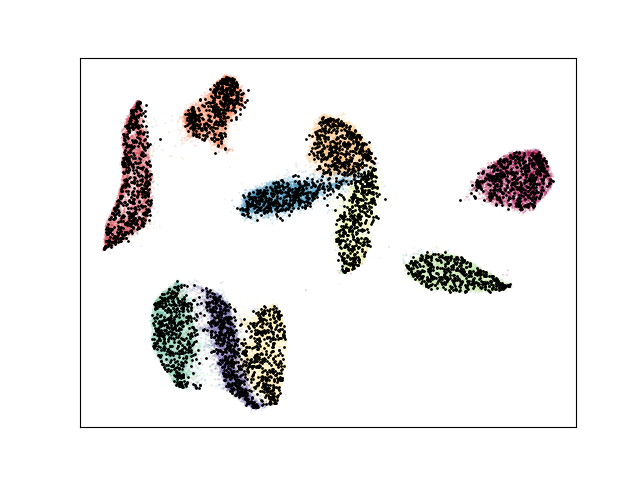

([], [])

In [10]:
emb_set1 = np.concatenate((embA_ne5, embB_ne5))
#emb_set1 = map_rotate(emb_set1, rot_angle=-40)
y_emb_set1 = np.concatenate((y_SETA_ne5, y_SETB_ne5))

embA_rot5 = embA_ne5 #map_rotate(embA_ne5, rot_angle=40)



plt.figure()
#plt.title('EM_SET_1')
plt.scatter(-emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
#plt.scatter(embA_rot5[:,0], -embA_rot5[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.85, 8.35])
plt.ylim([-7.25, 7.43])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne5k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne5, embC_ne5))
#emb_set2 = map_rotate(emb_set2, rot_angle=-40)
y_emb_set2 = np.concatenate((y_SETA_ne5,y_SETC_ne5))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(-emb_set2[:,0], emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
#plt.scatter(embA_rot5[:,0], -embA_rot5[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.85, 8.35])
plt.ylim([-7.25, 7.43])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne5k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne5, embB_ne5, embC_ne5))
#emb_set = map_rotate(emb_set, rot_angle=40)
y_emb_set = np.concatenate((y_SETA_ne5, y_SETB_ne5, y_SETC_ne5))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')
plt.scatter(embA_rot5[:,0], -embA_rot5[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

In [11]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 1000
nB = 29500
nC = 29500

#SETA = X_train_rp[:nA]
y_SETA_ne1 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne1 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne1 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)

with open('MNIST_Aligned_NE_1_29.5_29.5.npy', 'rb') as f:
    embA_ne1 = np.load(f)
    embB_ne1 = np.load(f)
    embC_ne1 = np.load(f)

In [12]:
T1_ne1 = my_trustworthiness(np.concatenate((embA_ne1,embB_ne1,embC_ne1)),sort_idx,k_nn)

print(T1_ne1)

0.9503114344690403


In [13]:
emb_set1 = np.concatenate((embA_ne1, embB_ne1))
emb_set1 = map_rotate(emb_set1, rot_angle=10)
y_emb_set1 = np.concatenate((y_SETA_ne1, y_SETB_ne1))

embA_rot1 = map_rotate(embA_ne1, rot_angle=-40)

plt.figure()
#plt.title('EM_SET_1')
plt.scatter(-emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot1[:,0], -embA_rot1[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-10.25, 8.8])
plt.ylim([-7.6, 6.75])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne1k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne1, embC_ne1))
emb_set2 = map_rotate(emb_set2, rot_angle=10)
y_emb_set2 = np.concatenate((y_SETA_ne1,y_SETC_ne1))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(-emb_set2[:,0], emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot1[:,0], -embA_rot1[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-10.25, 8.8])
plt.ylim([-7.6, 6.75])


#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne1k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne1, embB_ne1, embC_ne1))
emb_set = map_rotate(emb_set, rot_angle=-40)
y_emb_set = np.concatenate((y_SETA_ne1, y_SETB_ne1, y_SETC_ne1))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot1[:,0], -embA_rot1[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

([], [])

In [14]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 100
nB = 29950
nC = 29950

#SETA = X_train_rp[:nA]
y_SETA_ne100 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne100 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne100 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)

with open('MNIST_Aligned_NE_0.1_29.95_29.95.npy', 'rb') as f:
    embA_ne100 = np.load(f)
    embB_ne100 = np.load(f)
    embC_ne100 = np.load(f)

In [15]:
T1_ne100 = my_trustworthiness(np.concatenate((embA_ne100,embB_ne100,embC_ne100)),sort_idx,k_nn)

print(T1_ne100)

0.9374786622105169


In [16]:
emb_set1 = np.concatenate((embA_ne100, embB_ne100))
#emb_set1 = map_rotate(emb_set1, rot_angle=-40)
y_emb_set1 = np.concatenate((y_SETA_ne100, y_SETB_ne100))

embA_rot100 = embA_ne100 #map_rotate(embA_ne100, rot_angle=40)

plt.figure()
#plt.title('EM_SET_1')
plt.scatter(-emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-8.45, 8.45])
plt.ylim([-8.45, 8.45])


#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne100_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne100, embC_ne100))
#emb_set2 = map_rotate(emb_set2, rot_angle=-40)
y_emb_set2 = np.concatenate((y_SETA_ne100, y_SETC_ne100))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(-emb_set2[:,0], emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-8.45, 8.45])
plt.ylim([-8.45, 8.45])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne100_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne100, embB_ne100, embC_ne100))
#emb_set = map_rotate(emb_set, rot_angle=-40)

y_emb_set = np.concatenate((y_SETA_ne100, y_SETB_ne100, y_SETC_ne100))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

([], [])

In [17]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 20000
nB = 20000
nC = 20000

#SETA = X_train_rp[:nA]
y_SETA_ne20 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne20 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne20 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)

with open('MNIST_Aligned_NE_20_20_20.npy', 'rb') as f:
    embA_ne20 = np.load(f)
    embB_ne20 = np.load(f)
    embC_ne20 = np.load(f)

In [18]:
T1_ne100 = my_trustworthiness(np.concatenate((embA_ne20,embB_ne20,embC_ne20)),sort_idx,k_nn)

print(T1_ne100)

0.9543126978041516


In [19]:
emb_set1 = np.concatenate((embA_ne20, embB_ne20))
emb_set1 = map_rotate(emb_set1, rot_angle=10)
y_emb_set1 = np.concatenate((y_SETA_ne20, y_SETB_ne20))

embA_rot20 = embA_ne20 #map_rotate(embA_ne100, rot_angle=40)

plt.figure()
#plt.title('EM_SET_1')
plt.scatter(-emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.7, 9.7])
plt.ylim([-8.20, 7.45])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('mnist_figures/ne20k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne20, embC_ne20))
emb_set2 = map_rotate(emb_set2, rot_angle=10)
y_emb_set2 = np.concatenate((y_SETA_ne20, y_SETC_ne20))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(-emb_set2[:,0], emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.7, 9.7])
plt.ylim([-8.20, 7.45])


#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('fmnist_figures/ne20k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne20, embB_ne20, embC_ne20))
#emb_set = map_rotate(emb_set, rot_angle=-40)

y_emb_set = np.concatenate((y_SETA_ne20, y_SETB_ne20, y_SETC_ne20))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

([], [])

In [20]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 3000
nRest = 11400

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(5):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

with open('MNIST_Aligned_NE_5_SETS_3000_11400.npy', 'rb') as f:
    embA_5s = np.load(f)
    emB_sets = np.load(f)
    
TRST = np.zeros(len(emB_sets))

    
for i in range(len(emB_sets)):
    emb_set_ns5 = np.concatenate((embA_5s, emB_sets[i]))
    emb_set_ns5 = map_rotate(emb_set_ns5, rot_angle=40)
    y_emb_set_ns5 = np.concatenate((y_SETA, y_SETS[i]))
    
    sort_idx_ns5, _ = get_first_order_graph(DATA[i],n_neighbors=DATA[i].shape[0]-1)
    TRST[i] = my_trustworthiness(emb_set_ns5, sort_idx_ns5, k_nn)
    

    #embA_rot20 = embA_ne20 #map_rotate(embA_ne100, rot_angle=40)

    plt.figure()
    #plt.title('EM_SET_1')
    plt.scatter(emb_set_ns5[:,0], -emb_set_ns5[:,1], c=y_emb_set_ns5, s=0.01, cmap='Spectral')

    #plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
    plt.xticks([],[])
    plt.yticks([],[])

    plt.xlim([-10.60, 7.9])
    plt.ylim([-7.00, 8.9])

    #cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    #cbar.set_ticks(np.arange(10))
    #cbar.set_ticklabels(classes)

    plt.savefig('mnist_figures/ne_umap5split_3000_11400_'+str(i)+'.png', dpi=fig.dpi, bbox_inches='tight')
    


    

in loop
in loop
in loop
in loop
in loop
out of loop
(3000, 784) (5, 11400, 784) (11400, 784) (5, 14400, 784) 5
Completed  10000  of  14400


<IPython.core.display.Javascript object>

Completed  10000  of  14400


<IPython.core.display.Javascript object>

Completed  10000  of  14400


<IPython.core.display.Javascript object>

Completed  10000  of  14400


<IPython.core.display.Javascript object>

Completed  10000  of  14400


<IPython.core.display.Javascript object>

In [21]:
for i in range(len(emB_sets)):
    print('T', i, ': ', TRST[i])
    
    
total_emb = np.concatenate(emB_sets)
total_emb = np.concatenate((embA_5s, total_emb))

T_5sets = my_trustworthiness(total_emb, sort_idx, 5)

print('Trustworthiness: ', T_5sets)

T 0 :  0.9538853742048051
T 1 :  0.9527584470153172
T 2 :  0.9540023450528071
T 3 :  0.9540215329890063
T 4 :  0.9544407811438453
Trustworthiness:  0.9500016303840512
